![zad1.png](images/note4/zad1.png)

In [3]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

# Set the confidence level
alpha = 0.05  # 5% tail

# 1. Compute VaR at level alpha for standard normal
VaR_alpha = -norm.ppf(alpha)  # Note the minus sign for losses

# 2. ES using the PDF integral definition
def integrand_pdf(x):
    return x * norm.pdf(x)

# Integrate from -infinity to -VaR_alpha
integral_pdf, _ = quad(integrand_pdf, -np.inf, -VaR_alpha)
ES_pdf = -integral_pdf / alpha

# 3. ES using the quantile (VaR) integral definition
def VaR_gamma(gamma):
    return -norm.ppf(gamma)

integral_var, _ = quad(VaR_gamma, 0, alpha)
ES_var = integral_var / alpha

# Print results
print(f"ES (PDF integral definition): {ES_pdf:.5f}")
print(f"ES (Quantile integral definition): {ES_var:.5f}")
print(f"Difference: {abs(ES_pdf - ES_var):.5e}")

ES (PDF integral definition): 2.06271
ES (Quantile integral definition): 2.06271
Difference: 1.05733e-11


![zad2.png](images/note4/zad2.png)

ES_norm(0.01) = 2.6652
ES_norm(0.05) = 2.0627
ES_norm(0.1) = 1.7550


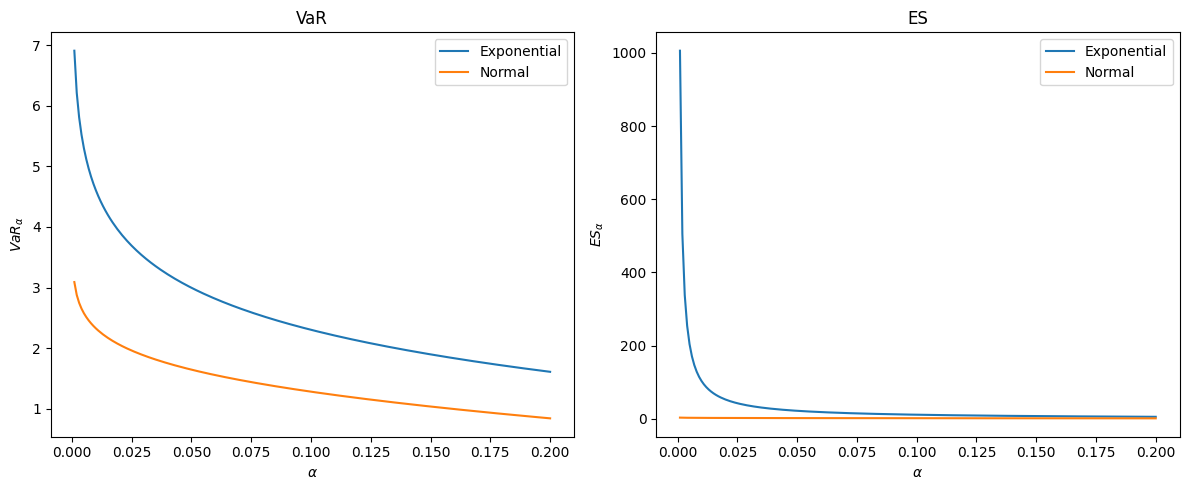

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

alphas = np.linspace(0.001, 0.2, 200)  # avoid 0 to prevent log(0) or inf

# exponential distribution
VaR_exp = -np.log(alphas)
ES_exp = (1 - alphas * np.log(alphas) - alphas) / alphas

# normal distribution
VaR_norm = -norm.ppf(alphas)

def ES_normal(alpha):
    # integrate VaR_gamma from 0 to alpha
    integrand = lambda gamma: -norm.ppf(gamma)
    integral, _ = quad(integrand, 0, alpha)
    return integral / alpha

ES_norm = np.array([ES_normal(a) for a in alphas])

# to check if the ES_normal function is correct and its not constant 0 like it looks in the plot
for a in [0.01, 0.05, 0.1]:
    print(f"ES_norm({a}) = {ES_normal(a):.4f}")

# --- ANALYTIC FORMULAS ---
# For exponential distribution (lambda=1):
#   VaR_alpha(X) = -ln(alpha)
#   ES_alpha(X) = [1 - alpha*ln(alpha) - alpha] / alpha
#
# For standard normal distribution (mu=0, sigma=1):
#   VaR_alpha(X) = -Phi^{-1}(alpha)
#   ES_alpha(X) = -(1/alpha) * integral_0^alpha Phi^{-1}(gamma) dgamma
#
# Where Phi^{-1} is the quantile (inverse CDF) of the standard normal distribution.



plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(alphas, VaR_exp, label='Exponential')
plt.plot(alphas, VaR_norm, label='Normal')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$VaR_\alpha$')
plt.title('VaR')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(alphas, ES_exp, label='Exponential')
plt.plot(alphas, ES_norm, label='Normal')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$ES_\alpha$')
plt.title('ES')
plt.legend()

plt.tight_layout()
plt.show()

![zad32.png](images/note4/zad31.png)  
![zad31.png](images/note4/zad32.png)

**(a) Derivation of Value at Risk (VaR) and Expected Shortfall (ES) for Normally Distributed Returns**

We are given that the return over time $t$ is modeled as:

$$
R = S(t) - S(0) = S(0) \mu t + S(0) \sigma \sqrt{t}\, \xi,
$$

where $\xi \sim \mathcal{N}(0, 1)$. Thus, $R \sim \mathcal{N}(S(0) \mu t, S(0)^2 \sigma^2 t)$.

---

### 1. Value at Risk (VaR)

"There’s a 𝛼 probability that I’ll lose at least this much (or more)."

By definition:

$$
P(R \leq -\mathrm{VaR}_\alpha) = \alpha
$$

We standardize $R$:

$$
Z = \frac{R - S(0) \mu t}{S(0) \sigma \sqrt{t}} \sim \mathcal{N}(0, 1)
$$

So:

$$
P\left(Z \leq \frac{-\mathrm{VaR}_\alpha - S(0) \mu t}{S(0) \sigma \sqrt{t}}\right) = \alpha
$$

Using the standard normal CDF $\Phi$:

$$
\Phi\left(\frac{-\mathrm{VaR}_\alpha - S(0) \mu t}{S(0) \sigma \sqrt{t}}\right) = \alpha
$$

Apply the inverse CDF $\Phi^{-1}$:

$$
\frac{-\mathrm{VaR}_\alpha - S(0) \mu t}{S(0) \sigma \sqrt{t}} = \Phi^{-1}(\alpha)
$$

Solve for $-\mathrm{VaR}_\alpha$:

$$
-\mathrm{VaR}_\alpha = S(0) \mu t + S(0) \sigma \sqrt{t}\, \Phi^{-1}(\alpha)
$$

---

### 2. Expected Shortfall (ES) - 

"If things go really badly (worse than my VaR) — then how bad is the average loss?"

We use the alternative definition:

$$
ES_\alpha = \frac{1}{\alpha} \int_0^\alpha -\mathrm{VaR}_\gamma \, d\gamma
$$

From earlier, $-\mathrm{VaR}_\gamma = S(0) \mu t + S(0) \sigma \sqrt{t} \Phi^{-1}(\gamma)$. So:

$$
ES_\alpha = \frac{1}{\alpha} \int_0^\alpha \left(S(0) \mu t + S(0) \sigma \sqrt{t} \Phi^{-1}(\gamma)\right) d\gamma
$$

Split the integral:

$$
ES_\alpha = S(0) \mu t + \frac{S(0) \sigma \sqrt{t}}{\alpha} \int_0^\alpha \Phi^{-1}(\gamma) d\gamma
$$

---



In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

# === Parameters ===
S0 = 100      # initial share price
mu_annual = 0.10  # 10% annual return
days_per_year = 250
t_day = 1 / days_per_year
# mu_annual = mu_annual / days_per_year

# === (a) Symbolic form (derived above):

# General function for VaR and ES
def compute_VaR_ES(alpha, mu, sigma, t):
    sqrt_t = np.sqrt(t)
    
    # VaR using the quantile function
    var = mu * t * S0 + sigma * sqrt_t * S0 * norm.ppf(alpha)
    
    # ES using integral of the quantile function
    integrand = lambda gamma: norm.ppf(gamma)
    integral, _ = quad(integrand, 0, alpha) # ∫ from 0 to α of Φ⁻¹(γ) dγ
    es = S0 * mu * t + S0 * (sigma * sqrt_t / alpha) * integral

    return var, es

# === (b)
sigma_annual = 0.20
alpha = 1 / 250  # one per year
VaR_b, ES_b = compute_VaR_ES(alpha, mu_annual, sigma_annual, t_day)

print(f"(b) Daily -VaR: {VaR_b:.4f}, ES: {ES_b:.4f}")

# === (c) 30% volatility
VaR_c, ES_c = compute_VaR_ES(alpha, mu_annual, 0.30, t_day)

print(f"(c) Higher Volatility -VaR: {VaR_c:.4f}, ES: {ES_c:.4f}")

# === (d) Assume 2, 3, ..., 5 exceedances/year
print("(d)")
for k in [1, 2, 3, 4, 5]:
    alpha_k = k / days_per_year
    VaR_d, ES_d = compute_VaR_ES(alpha_k, mu_annual, sigma_annual, t_day)
    print(f"\tk={k}: alpha={alpha_k:.4f}, -VaR={VaR_d:.4f}, ES={ES_d:.4f}")

# === (e) Horizon increased to 2, 3, ... years
print("(e)")
for years in [1, 2, 3, 4, 5]:
    t_e = years
    alpha_e = 1 / (days_per_year * years)
    VaR_e, ES_e = compute_VaR_ES(alpha_e, mu_annual, sigma_annual, t_day)
    print(f"\tyears={years}: alpha={alpha_e:.5f}, -VaR={VaR_e:.4f}, ES={ES_e:.4f}")

# === (f) Weekly horizon
t_week = 5 / days_per_year
alpha_f = 1 / 52  # one exceedance per year
VaR_f, ES_f = compute_VaR_ES(alpha_f, mu_annual, sigma_annual, t_week)

print(f"\n(f) Weekly -VaR: {VaR_f:.4f}, ES: {ES_f:.4f}")


(b) Daily -VaR: -3.3146, ES: -3.7064
(c) Higher Volatility -VaR: -4.9919, ES: -5.5796
(d)
	k=1: alpha=0.0040, -VaR=-3.3146, ES=-3.7064
	k=2: alpha=0.0080, -VaR=-3.0071, ES=-3.4258
	k=3: alpha=0.0120, -VaR=-2.8151, ES=-3.2523
	k=4: alpha=0.0160, -VaR=-2.6725, ES=-3.1245
	k=5: alpha=0.0200, -VaR=-2.5578, ES=-3.0222
(e)
	years=1: alpha=0.00400, -VaR=-3.3146, ES=-3.7064
	years=2: alpha=0.00200, -VaR=-3.6006, ES=-3.9699
	years=3: alpha=0.00133, -VaR=-3.7595, ES=-4.1172
	years=4: alpha=0.00100, -VaR=-3.8689, ES=-4.2191
	years=5: alpha=0.00080, -VaR=-3.9519, ES=-4.2966

(f) Weekly -VaR: -5.6546, ES: -6.6880


![zad41.png](images/note4/zad41.png)  
![zad42.png](images/note4/zad42.png)

In [12]:
import numpy as np
# a)
prices = np.loadtxt("dat_St.txt")

# liczba dni handlowych w roku
T = 250

# dzienne logarytmiczne stopy zwrotu
log_returns = np.diff(np.log(prices))

# średnia dzienna logarytmiczna stopa zwrotu
mean_daily_log_return = np.mean(log_returns)

# odchylenie standardowe
std_daily_log_return = np.std(log_returns, ddof=1)

annualized_volatility = np.sqrt(T) * std_daily_log_return
annualized_mean_return = T * mean_daily_log_return

print("volatility:", round(annualized_volatility, 6))
print("mean return:", round(annualized_mean_return, 6))


FileNotFoundError: dat_St.txt not found.

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

# b)

t = 1 / T
initial_investment = 10_000_000

VaR_values = []
ES_values = []

daily_log_returns = np.log(prices[1:] / prices[:-1])
mean_daily_log_return = np.mean(daily_log_returns)
sd_daily_log_return = np.std(daily_log_returns)
annualized_volatility_from_sd = np.sqrt(T) * sd_daily_log_return
annualized_mean_return_from_daily = 250 * mean_daily_log_return
mu_daily = mean_daily_log_return
sigma_daily = sd_daily_log_return

results = []
for alpha in alphas:
    
    z_alpha = norm.ppf(alpha)

    daily_VaR_log_return = - (mu_daily + z_alpha * sigma_daily)

    pdf_z_alpha = norm.pdf(z_alpha)
    daily_ES_log_return = - (mu_daily - sigma_daily * (pdf_z_alpha / alpha))

    VaR_money_abs = initial_investment * daily_VaR_log_return
    ES_money_abs = initial_investment * daily_ES_log_return

    VaR_values.append(-VaR_money_abs)
    ES_values.append(-ES_money_abs)

for i, alpha in enumerate(alphas):
    print(f"Tygodniowy poziom istotności α = {alpha:.2f}")
    print(f"  VaR (Gaussowskie przybliżenie): {VaR_values[i]:,.2f} PLN")
    print(f"  ES  (Gaussowskie przybliżenie): {ES_values[i]:,.2f} PLN\n")




Tygodniowy poziom istotności α = 0.01
  VaR (Gaussowskie przybliżenie): -292,261.59 PLN
  ES  (Gaussowskie przybliżenie): -335,480.17 PLN

Tygodniowy poziom istotności α = 0.05
  VaR (Gaussowskie przybliżenie): -205,344.67 PLN
  ES  (Gaussowskie przybliżenie): -258,637.90 PLN

Tygodniowy poziom istotności α = 0.10
  VaR (Gaussowskie przybliżenie): -159,009.59 PLN
  ES  (Gaussowskie przybliżenie): -219,390.47 PLN

Tygodniowy poziom istotności α = 0.20
  VaR (Gaussowskie przybliżenie): -102,901.43 PLN
  ES  (Gaussowskie przybliżenie): -174,092.07 PLN



In [ ]:
# c)


weekly_VaR = []
weekly_ES = []

t = 5

daily_log_returns = np.log(prices[1:] / prices[:-1])

mean_daily_log_return = np.mean(daily_log_returns)
sd_daily_log_return = np.std(daily_log_returns)

mu_daily = mean_daily_log_return
sigma_daily = sd_daily_log_return

for alpha in alphas:
    z_alpha = norm.ppf(alpha)

    weekly_VaR_log_return_magnitude = - (mu_daily * t + z_alpha * sigma_daily * np.sqrt(t))

    pdf_z_alpha = norm.pdf(z_alpha)
    weekly_ES_log_return_magnitude = - (mu_daily * t - sigma_daily * np.sqrt(t) * (pdf_z_alpha / alpha))

    VaR_money_weekly = initial_investment * weekly_VaR_log_return_magnitude
    ES_money_weekly = initial_investment * weekly_ES_log_return_magnitude

    weekly_VaR.append(-VaR_money_weekly)
    weekly_ES.append(-ES_money_weekly)

print("--- Obliczenia dla tygodniowego VaR i ES (wartość pieniężna) ---")
for i, alpha in enumerate(alphas):
    print(f"Tygodniowy poziom istotności α = {alpha:.2f}")
    print(f"  VaR (Gaussowskie przybliżenie): {weekly_VaR[i]:,.2f} PLN")
    print(f"  ES  (Gaussowskie przybliżenie): {weekly_ES[i]:,.2f} PLN\n")

--- Obliczenia dla tygodniowego VaR i ES (wartość pieniężna) ---
Tygodniowy poziom istotności α = 0.01
  VaR (Gaussowskie przybliżenie): -641,250.78 PLN
  ES  (Gaussowskie przybliżenie): -737,890.48 PLN

Tygodniowy poziom istotności α = 0.05
  VaR (Gaussowskie przybliżenie): -446,898.65 PLN
  ES  (Gaussowskie przybliżenie): -566,065.94 PLN

Tygodniowy poziom istotności α = 0.10
  VaR (Gaussowskie przybliżenie): -343,290.25 PLN
  ES  (Gaussowskie przybliżenie): -478,306.02 PLN

Tygodniowy poziom istotności α = 0.20
  VaR (Gaussowskie przybliżenie): -217,828.59 PLN
  ES  (Gaussowskie przybliżenie): -377,015.70 PLN



In [ ]:
# d)

investment_value = 10_000_000

# dzienne zmiany ceny (ΔS)
delta_S = np.diff(prices)

# przeskalowanie zmian do wartości inwestycji: ΔS * inwestycja / cena poprzedniego dnia
scaled_delta_S = delta_S * (investment_value / prices[:-1])

# sortowanie strat
sorted_losses = np.sort(-scaled_delta_S)  # znak minus, bo interesują nas straty
n = len(sorted_losses)

# obliczenia empiryczne VaR i ES dla każdego poziomu istotności
empirical_VaR = [] # straty są posortowane od największej straty do najmniejszej, bierzemy k-tą najgorszą stratę, gdzie k wyliczane jest w pętli
empirical_ES = [] # średnia najgorszych strat

for alpha in alphas:
    k = int(np.floor(alpha * n)) # liczba dni odpowiadająca alpha
    var_alpha = sorted_losses[k]
    es_alpha = sorted_losses[:k].mean() if k > 0 else var_alpha
    empirical_VaR.append(var_alpha)
    empirical_ES.append(es_alpha)

for i, alpha in enumerate(alphas):
    print(f"Poziom istotności α = {alpha:.2f}")
    print(f"  Empiryczny VaR: {empirical_VaR[i]:,.2f} PLN")
    print(f"  Empiryczny ES : {empirical_ES[i]:,.2f} PLN\n")


Poziom istotności α = 0.01
  Empiryczny VaR: -305,208.23 PLN
  Empiryczny ES : -361,949.30 PLN

Poziom istotności α = 0.05
  Empiryczny VaR: -224,423.78 PLN
  Empiryczny ES : -276,611.88 PLN

Poziom istotności α = 0.10
  Empiryczny VaR: -170,177.67 PLN
  Empiryczny ES : -234,695.16 PLN

Poziom istotności α = 0.20
  Empiryczny VaR: -107,846.37 PLN
  Empiryczny ES : -186,014.29 PLN



In [ ]:
# e)
weekly_prices = prices[::5]

# obliczenie tygodniowych zmian ceny (ΔS_week)
delta_S_week = np.diff(weekly_prices)

# przeskalowanie do zmian wartości inwestycji
scaled_delta_S_week = delta_S_week * (investment_value / weekly_prices[:-1])

sorted_weekly_losses = np.sort(-scaled_delta_S_week)
n_week = len(sorted_weekly_losses)

empirical_VaR_week = []
empirical_ES_week = []

for alpha in alphas:
    k = int(np.floor(alpha * n_week))
    var_alpha = sorted_weekly_losses[k]
    es_alpha = sorted_weekly_losses[:k].mean() if k > 0 else var_alpha
    empirical_VaR_week.append(var_alpha)
    empirical_ES_week.append(es_alpha)

for i, alpha in enumerate(alphas):
    print(f"Tygodniowy poziom istotności α = {alpha:.2f}")
    print(f"  Empiryczny VaR: {empirical_VaR_week[i]:,.2f} PLN")
    print(f"  Empiryczny ES : {empirical_ES_week[i]:,.2f} PLN\n")

Tygodniowy poziom istotności α = 0.01
  Empiryczny VaR: -667,035.19 PLN
  Empiryczny ES : -688,611.40 PLN

Tygodniowy poziom istotności α = 0.05
  Empiryczny VaR: -491,860.36 PLN
  Empiryczny ES : -606,282.30 PLN

Tygodniowy poziom istotności α = 0.10
  Empiryczny VaR: -394,848.57 PLN
  Empiryczny ES : -529,882.01 PLN

Tygodniowy poziom istotności α = 0.20
  Empiryczny VaR: -257,647.49 PLN
  Empiryczny ES : -426,297.38 PLN



VaR tygodniowy jest mniej więcej 2× większy niż dzienny co jest zgodne z teorią (przy niezależnych stopach zwrotu zmienność rośnie proporcjonalnie do pierwiastka z liczby dni).

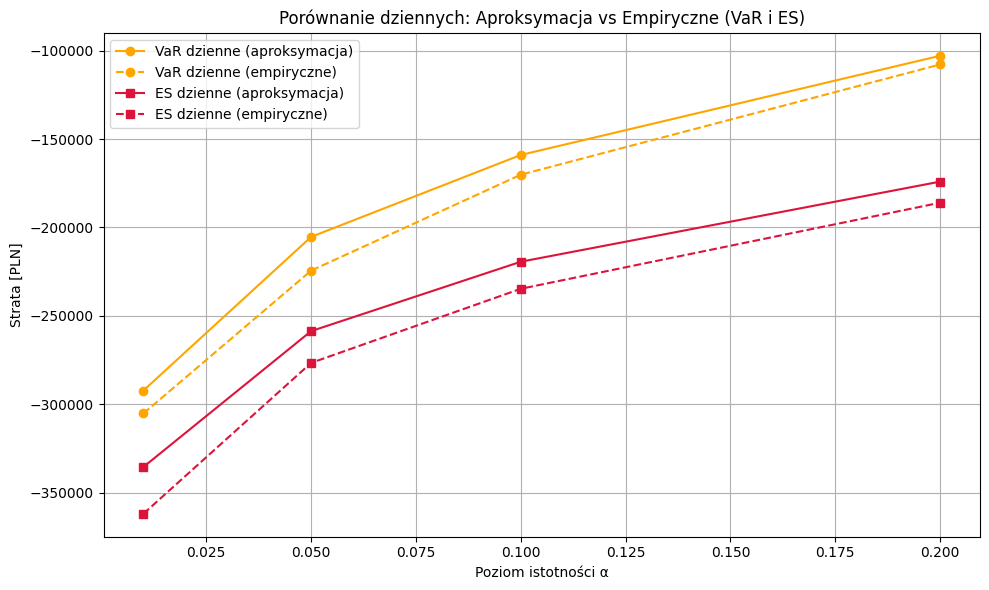

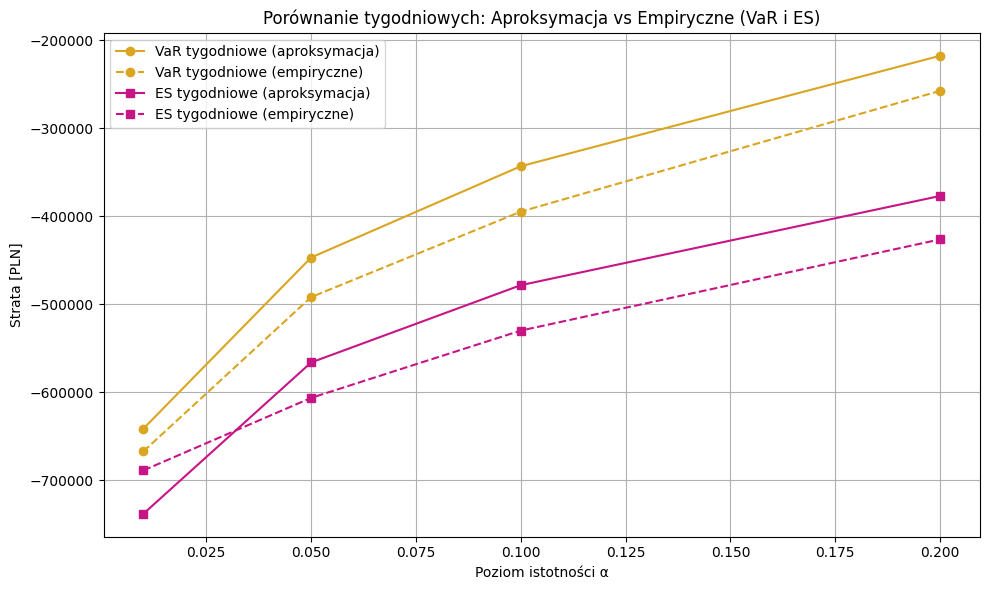

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# f)

plt.figure(figsize=(10, 6))
plt.plot(alphas, VaR_values, label='VaR dzienne (aproksymacja)', marker='o', color='orange')
plt.plot(alphas, empirical_VaR, label='VaR dzienne (empiryczne)', marker='o', linestyle='--', color='orange')
plt.plot(alphas, ES_values, label='ES dzienne (aproksymacja)', marker='s', color='crimson')
plt.plot(alphas, empirical_ES, label='ES dzienne (empiryczne)', marker='s', linestyle='--', color='crimson')
plt.title('Porównanie dziennych: Aproksymacja vs Empiryczne (VaR i ES)')
plt.xlabel('Poziom istotności α')
plt.ylabel('Strata [PLN]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Tygodniowy wykres
plt.figure(figsize=(10, 6))
plt.plot(alphas, weekly_VaR, label='VaR tygodniowe (aproksymacja)', marker='o', color='goldenrod')
plt.plot(alphas, empirical_VaR_week, label='VaR tygodniowe (empiryczne)', marker='o', linestyle='--', color='goldenrod')
plt.plot(alphas, weekly_ES, label='ES tygodniowe (aproksymacja)', marker='s', color='mediumvioletred')
plt.plot(alphas, empirical_ES_week, label='ES tygodniowe (empiryczne)', marker='s', linestyle='--', color='mediumvioletred')
plt.title('Porównanie tygodniowych: Aproksymacja vs Empiryczne (VaR i ES)')
plt.xlabel('Poziom istotności α')
plt.ylabel('Strata [PLN]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()